# Asthma Diagnosis with a 1‑bit (BNN) Classifier

This notebook loads the provided dataset, removes unnecessary columns, and trains a compact **Binarized Neural Network (BNN)** to predict whether a patient is asthmatic (`Diagnosis` = 1) or not (`Diagnosis` = 0).

**Pipeline overview**
1. Load data from `asthma_disease_data.csv`
2. Clean & feature select (drop identifiers, non‑predictive columns, near‑constant columns)
3. Standardize numeric features
4. Train a small fully‑connected BNN (binarized weights & activations)
5. Evaluate (accuracy, F1, ROC‑AUC, confusion matrix)
6. Export a lightweight artifact for deployment


In [18]:

# === Setup ===
import os, math, json, random, numpy as np, pandas as pd
from pathlib import Path

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

CSV_PATH = Path('asthma_disease_data.csv')  # update if needed

assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head(3)


(2392, 29)


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,...,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,...,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,...,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,...,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid


## 1) Clean & Feature Selection

Rules:
- Drop obvious identifiers / leakage: `PatientID`, `DoctorInCharge` (object/string), but keep `Diagnosis` as target
- Auto‑drop columns with (a) >95% same value (near‑constant), (b) all‑null, or (c) duplicate columns
- Keep only numeric predictors; coerce booleans/ints/floats; leave target untouched


In [19]:

TARGET_CANDIDATES = ['Diagnosis', 'asthma', 'Asthma', 'is_asthmatic']
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break
assert target_col is not None, f"Target column not found; looked for {TARGET_CANDIDATES}"

# Identify identifier-like columns to drop (besides target)
id_like = []
for c in df.columns:
    if c == target_col: 
        continue
    if c.lower() in ['patientid','id','uuid','guid','recordid','doctorincharge','Ethnicity']:
        id_like.append(c)
    # Heuristic: object dtype that's not small categorical could be free text -> drop
    if df[c].dtype == 'object':
        nunique = df[c].nunique(dropna=True)
        if nunique > 20:
            id_like.append(c)

id_like = sorted(set(id_like))

# Remove all-null, near-constant, and duplicates
drop_cols = set(id_like)
for c in df.columns:
    if c == target_col: 
        continue
    s = df[c]
    if s.isna().all():
        drop_cols.add(c)
    else:
        # near-constant
        top_freq = s.value_counts(dropna=False).iloc[0] / len(s)
        if top_freq > 0.95:
            drop_cols.add(c)

# drop duplicate columns by values hash (excluding target)
seen = {}
for c in df.columns:
    if c == target_col or c in drop_cols: 
        continue
    key = tuple(pd.util.hash_pandas_object(df[c].fillna('__NA__')).values)
    if key in seen:
        drop_cols.add(c)
    else:
        seen[key] = c

df_clean = df.drop(columns=list(drop_cols), errors='ignore').copy()

# Keep only numeric predictors (int, float, bool)
predictors = [c for c in df_clean.columns if c != target_col]
non_numeric = [c for c in predictors if not pd.api.types.is_numeric_dtype(df_clean[c])]
df_clean = df_clean.drop(columns=non_numeric, errors='ignore')
predictors = [c for c in df_clean.columns if c != target_col]

print("Dropped columns:", sorted(drop_cols | set(non_numeric)))
print("Remaining predictors:", len(predictors))
print("Target:", target_col)
df_clean.head(3)


Dropped columns: ['DoctorInCharge', 'PatientID']
Remaining predictors: 26
Target: Diagnosis


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0


## 2) Train / Test Split + Scaling

In [20]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure target is binary 0/1
y_raw = df_clean[target_col].astype(int).values
assert set(np.unique(y_raw)).issubset({0,1}), "Target must be binary 0/1."

X = df_clean[predictors].astype(np.float32).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.1, random_state=SEED, stratify=y_raw
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

x_mean = scaler.mean_.astype(np.float32)
x_scale = scaler.scale_.astype(np.float32)
X_train.shape, X_test.shape


((2152, 26), (240, 26))

## 3) Define a Simple Fully‑Connected BNN

We binarize weights & activations to {−1, +1} during the forward pass (keep float32 shadows for updates).

In [21]:

import torch, torch.nn as nn, torch.nn.functional as F

torch.manual_seed(SEED)

class SignBinarize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.sign()
    @staticmethod
    def backward(ctx, g):
        # Straight-through estimator (clipped)
        return g.clamp_(-1, 1)

def binarize(x):
    return SignBinarize.apply(x)

class BinaryLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.kaiming_normal_(self.weight, nonlinearity='relu')
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None

    def forward(self, x):
        w_bin = binarize(self.weight)
        x_bin = binarize(x)
        out = F.linear(x_bin, w_bin, self.bias)
        return out

class BNN(nn.Module):
    def __init__(self, in_dim, hidden=[128, 64], p_drop=0.1):
        super().__init__()
        self.fc1 = BinaryLinear(in_dim, hidden[0])
        self.bn1 = nn.BatchNorm1d(hidden[0])
        self.fc2 = BinaryLinear(hidden[0], hidden[1])
        self.bn2 = nn.BatchNorm1d(hidden[1])
        self.out = BinaryLinear(hidden[1], 1)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        x = self.fc1(x); x = self.bn1(x); x = F.hardtanh(x); x = self.dropout(x)
        x = self.fc2(x); x = self.bn2(x); x = F.hardtanh(x); x = self.dropout(x)
        logit = self.out(x)  # binary logit
        return logit.squeeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## 4) Train

In [22]:

from torch.utils.data import TensorDataset, DataLoader

Xtr = torch.from_numpy(X_train).to(device)
ytr = torch.from_numpy(y_train.astype(np.float32)).to(device)
Xte = torch.from_numpy(X_test).to(device)
yte = torch.from_numpy(y_test.astype(np.float32)).to(device)

train_ds = TensorDataset(Xtr, ytr)
test_ds  = TensorDataset(Xte, yte)

train_loader = DataLoader(train_ds, batch_size=2000, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, drop_last=False)

model = BNN(in_dim=X_train.shape[1]).to(device)

def evaluate():
    model.eval()
    total_loss, n = 0.0, 0
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb)
            loss = loss_fn(logits, yb)
            total_loss += loss.item() * xb.size(0)
            n += xb.size(0)
            all_logits.append(logits.cpu())
            all_y.append(yb.cpu())
    logits = torch.cat(all_logits).numpy()
    y_true = torch.cat(all_y).numpy()
    y_prob = 1/(1+np.exp(-logits))
    y_pred = (y_prob >= 0.5).astype(int)
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = float('nan')
    return total_loss/n, acc, f1, auc



In [23]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()




best = {"epoch":-1, "loss":1e9, "acc":0, "state":None}
EPOCHS = 2036
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        # Clip to stabilize STE
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
    val_loss, acc, f1, auc = evaluate()
    if val_loss < best["loss"]:
        best.update({"epoch":epoch, "loss":val_loss, "acc":acc, "state":model.state_dict()})
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | val_loss={val_loss:.4f} acc={acc:.3f} f1={f1:.3f} auc={auc:.3f}")

# Load best
model.load_state_dict(best["state"])
print("Best @ epoch", best["epoch"], "val_loss", round(best["loss"],4), "acc", round(best["acc"],3))


Epoch 01 | val_loss=1.9330 acc=0.708 f1=0.079 auc=0.607
Epoch 05 | val_loss=2.2015 acc=0.658 f1=0.089 auc=0.548
Epoch 10 | val_loss=2.4648 acc=0.588 f1=0.075 auc=0.544
Epoch 15 | val_loss=1.9680 acc=0.658 f1=0.109 auc=0.637
Epoch 20 | val_loss=1.9681 acc=0.654 f1=0.144 auc=0.669
Epoch 25 | val_loss=2.0635 acc=0.629 f1=0.101 auc=0.615
Epoch 30 | val_loss=2.1009 acc=0.646 f1=0.124 auc=0.643
Epoch 35 | val_loss=2.0393 acc=0.617 f1=0.115 auc=0.663
Epoch 40 | val_loss=1.7265 acc=0.646 f1=0.141 auc=0.660
Epoch 45 | val_loss=1.7804 acc=0.654 f1=0.144 auc=0.664
Epoch 50 | val_loss=1.3975 acc=0.667 f1=0.130 auc=0.682
Epoch 55 | val_loss=1.6535 acc=0.667 f1=0.130 auc=0.638
Epoch 60 | val_loss=1.6126 acc=0.700 f1=0.122 auc=0.546
Epoch 65 | val_loss=1.4118 acc=0.683 f1=0.156 auc=0.686
Epoch 70 | val_loss=1.9414 acc=0.617 f1=0.061 auc=0.495
Epoch 75 | val_loss=1.3550 acc=0.696 f1=0.052 auc=0.577
Epoch 80 | val_loss=1.3996 acc=0.704 f1=0.145 auc=0.647
Epoch 85 | val_loss=1.7748 acc=0.671 f1=0.151 au

## 5) Detailed Evaluation

              precision    recall  f1-score   support

           0     0.9534    0.9868    0.9698       228
           1     0.2500    0.0833    0.1250        12

    accuracy                         0.9417       240
   macro avg     0.6017    0.5351    0.5474       240
weighted avg     0.9182    0.9417    0.9276       240

ROC-AUC: 0.7280701754385965


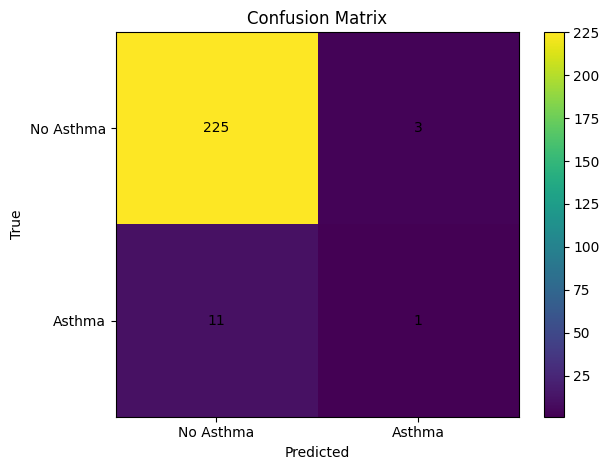

In [24]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    logits = model(torch.from_numpy(X_test).to(device)).cpu().numpy()
y_prob = 1/(1+np.exp(-logits))
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Asthma','Asthma'])
plt.yticks(tick_marks, ['No Asthma','Asthma'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()


## 6) Inference Helper

In [25]:

def predict_proba(batch_df: pd.DataFrame):
    # Apply the exact same cleaning pipeline
    tmp = batch_df.copy()
    # drop columns not in training predictors/target
    keep = predictors + [target_col]
    drop_extra = [c for c in tmp.columns if c not in keep]
    tmp = tmp.drop(columns=drop_extra, errors='ignore')
    # ensure columns order and presence
    for c in predictors:
        if c not in tmp.columns:
            tmp[c] = 0.0
    Xn = tmp[predictors].astype(np.float32).values
    Xn = (Xn - x_mean) / (x_scale + 1e-8)
    with torch.no_grad():
        logits = model(torch.from_numpy(Xn).to(device)).cpu().numpy()
    probs = 1/(1+np.exp(-logits))
    return probs

# Demo on first 5 rows
sample = df.iloc[:5].copy()
probs = predict_proba(sample)
pd.DataFrame({'Asthma_Prob': probs})


,Asthma_Prob
0,0.000005
1,0.447602
2,0.002004
3,0.000037
4,0.014624


## 7) Save Artifacts

In [26]:

out_dir = Path('/mnt/data/bnn_artifacts')
out_dir.mkdir(exist_ok=True, parents=True)
torch.save(model.state_dict(), out_dir/'bnn_state.pt')
with open(out_dir/'scaler.json','w') as f:
    json.dump({'mean': x_mean.tolist(), 'scale': x_scale.tolist(), 'predictors': predictors, 'target': target_col}, f)
print("Saved to", out_dir)


Saved to \mnt\data\bnn_artifacts
